Test if L1 normalizing Largrange Multipliers improve SVM by reducing number of support vector 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from scipy.stats import bernoulli

from classification.classifier import SVM
from classification.optimizer import QpDuel

def rotation2D(theta, x):
    """ x: 2D array"""
    import math
    R = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
    return R @ x

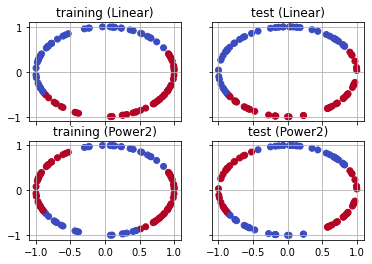

In [2]:
# generate data
num_data = 100
num_test = 1000
theta = np.pi/3
d = 2
C = 1000000
error_rate = 0.01

# training data
X = np.random.rand(num_data, d)
X = X - np.mean(X, 0) # standarderize E[X]=0
X = np.array([x/np.linalg.norm(x) for x in X]) # normalize ||X||=1

# test data
Xtest = np.random.rand(num_data, d)
Xtest = Xtest - np.mean(Xtest, 0) # standarderize E[Xtest]=0
Xtest = np.array([xtest/np.linalg.norm(xtest) for xtest in Xtest]) # normalize ||Xtest||=1

# bit flip label error
err = (-1)**bernoulli.rvs(error_rate, loc=0, size=num_data)

# label for linear kernel
y_linear = np.array([np.sign(x[0]) for x in rotation2D(theta, X.T).T])*err
ytest_linear = np.array([np.sign(x[0]) for x in rotation2D(theta, Xtest.T).T])

# label for power2 kernel
y_power2 = np.array([np.sign(x[0])*np.sign(x[1]) for x in rotation2D(theta, X.T).T])*err
ytest_power2 = np.array([np.sign(x[0])*np.sign(x[1]) for x in rotation2D(theta, Xtest.T).T])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
data = [X, Xtest, X, Xtest]
label = [y_linear, ytest_linear, y_power2, ytest_power2]
subtitle = ['training (Linear)', 'test (Linear)','training (Power2)','test (Power2)']
for i in range(len(ax)):
    ax[i].scatter(data[i][:,0], data[i][:,1], c=label[i], cmap=plt.cm.coolwarm)
    ax[i].grid()
    ax[i].set_title(subtitle[i])

In [3]:
linker = lambda X, Y: X@Y.T
cls_lin = SVM(X, y_linear, kernel= linker, name='linear kernel')
cls_lin_n = SVM(X, y_linear, kernel= linker, name='linear kernel (normalized)')
cls_lin.optimize(QpDuel, C=C, Probability=False)
cls_lin_n.optimize(QpDuel, C=C, Probability=True)

cls_pw2 = SVM(X, y_power2, kernel= 'power2', name='power2 kernel')
cls_pw2_n = SVM(X, y_power2, kernel= 'power2', name='power2 kernel (normalized)')
cls_pw2.optimize(QpDuel, C=C, Probability=False)
cls_pw2_n.optimize(QpDuel, C=C, Probability=True)

     pcost       dcost       gap    pres   dres
 0:  7.1422e+11 -2.3809e+13  4e+13  2e-01  4e-10
 1:  8.8667e+11 -3.0252e+12  5e+12  2e-02  2e-06
 2:  2.2638e+11 -6.1814e+11  9e+11  2e-03  2e-07
 3:  2.3579e+10 -9.8449e+10  1e+11  3e-10  2e-10
 4:  7.3149e+08 -1.1260e+10  1e+10  2e-10  2e-10
 5: -2.2292e+06 -2.9841e+08  3e+08  2e-16  2e-10
 6: -2.8807e+06 -9.1116e+06  6e+06  2e-10  2e-10
 7: -3.2243e+06 -6.4269e+06  3e+06  2e-10  2e-10
 8: -4.2591e+06 -7.3099e+06  3e+06  5e-10  2e-10
 9: -4.0411e+06 -7.0883e+06  3e+06  4e-10  2e-10
10: -4.2089e+06 -6.5900e+06  2e+06  6e-10  2e-10
11: -4.4752e+06 -6.8469e+06  2e+06  2e-10  2e-10
12: -5.5089e+06 -5.9141e+06  4e+05  8e-10  3e-10
13: -5.6087e+06 -5.7018e+06  9e+04  3e-10  3e-10
14: -5.6021e+06 -5.6895e+06  9e+04  1e-11  3e-10
15: -5.6329e+06 -5.6339e+06  1e+03  1e-11  4e-10
16: -5.6332e+06 -5.6332e+06  1e+01  3e-11  3e-10
17: -5.6332e+06 -5.6332e+06  1e-01  3e-10  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dre

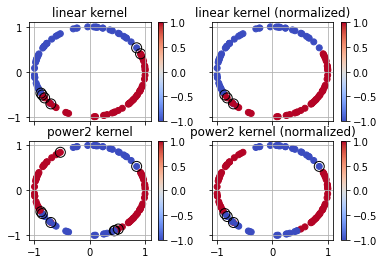

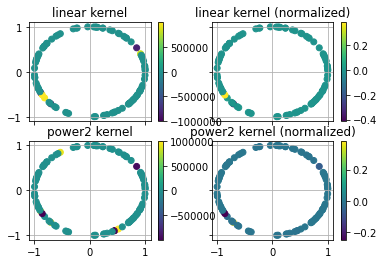

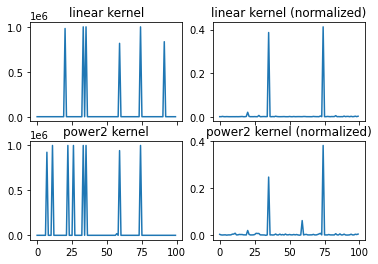

In [4]:
compare_linAndpower2_Normalized_sv, ax = plt.subplots(2,2, sharex=True, sharey=True)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    clses[i].plot(ax[i], sv=True)

compare_linAndpower2_Normalized_, ax = plt.subplots(2,2, sharex=True, sharey=True)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    clses[i].plot(ax[i], sv=False)

compare_linAndpower2_Normalized_alpha, ax = plt.subplots(2,2, sharex=True, sharey=False)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    ax[i].plot(clses[i].alpha)
    ax[i].set_title(clses[i].name)

In [5]:
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
test_label = [ytest_linear, ytest_linear, ytest_power2, ytest_power2]
for i in range(len(clses)):
    print('Performance of', clses[i].name, 'is', clses[i].check_perfomance(Xtest, test_label[i]))

Performance of linear kernel is 0.99
Performance of linear kernel (normalized) is 0.95
Performance of power2 kernel is 0.99
Performance of power2 kernel (normalized) is 0.99
